In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.generate as generate
import model.image_unet as image_unet
import model.util as model_util
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import os

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Define the branches and create the data loader

In [3]:
# classes = [0, 4, 9]
# branch_defs = [
#     ((0, 4, 9), 0.5, 1),
#     ((0,), 0, 0.5),
#     ((4, 9), 0.35, 0.5),
#     ((4,), 0, 0.35),
#     ((9,), 0, 0.35)
# ]

# classes = [0, 4, 7, 9]
# branch_defs = [((0, 4, 7, 9), 0, 1)]

classes = list(range(10))
branch_defs = [((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 0.4854854854854855, 1), ((1, 2, 3, 4, 5, 6, 7, 8, 9), 0.44744744744744747, 0.4854854854854855), ((2, 3, 4, 5, 6, 7, 8, 9), 0.43343343343343343, 0.44744744744744747), ((2, 3, 4, 5, 7, 8, 9), 0.4164164164164164, 0.43343343343343343), ((3, 4, 5, 7, 8, 9), 0.3743743743743744, 0.4164164164164164), ((3, 4, 5, 8, 9), 0.3683683683683684, 0.3743743743743744), ((3, 4, 5, 9), 0.35235235235235235, 0.3683683683683684), ((3, 4, 5), 0.3483483483483483, 0.35235235235235235), ((3, 5), 0.27127127127127126, 0.3483483483483483), ((0,), 0, 0.4854854854854855), ((1,), 0, 0.44744744744744747), ((6,), 0, 0.43343343343343343), ((2,), 0, 0.4164164164164164), ((7,), 0, 0.3743743743743744), ((8,), 0, 0.3683683683683684), ((9,), 0, 0.35235235235235235), ((4,), 0, 0.3483483483483483), ((5,), 0, 0.27127127127127126), ((3,), 0, 0.27127127127127126)]

dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

# Limit classes
inds = np.isin(dataset.targets, classes)
dataset.data = dataset.data[inds]
dataset.targets = dataset.targets[inds]

data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)
input_shape = next(iter(data_loader))[0].shape[1:]

In [4]:
# TODO: this is currently rather inefficient; a decision-tree-style structure
# would be better

def class_time_to_branch(c, t):
    """
    Given a class and a time (both scalars), return the
    corresponding branch index.
    """
    for i, branch_def in enumerate(branch_defs):
        if c in branch_def[0] and t >= branch_def[1] and t <= branch_def[2]:
            return i
    raise ValueError("Undefined class and time")
        
def class_time_to_branch_tensor(c, t):
    """
    Given tensors of classes and a times, return the
    corresponding branch indices as a tensor.
    """
    return torch.tensor([
        class_time_to_branch(c_i, t_i) for c_i, t_i in zip(c, t)
    ], device=DEVICE)

### Create the model

In [5]:
# Create the SDE and model
sde = sdes.VariancePreservingSDE(0.1, 20, input_shape)

t_limit = 1
model = image_unet.MultitaskMNISTUNetTimeConcat(
    len(branch_defs), t_limit=t_limit
).to(DEVICE)

os.environ["MODEL_DIR"] = "/gstore/data/resbioai/tsenga5/branched_diffusion/models/trained_models/mnist_continuous_alldigits"

import model.train_continuous_model as train_continuous_model  # Import this AFTER setting environment

### Show the forward-diffusion process

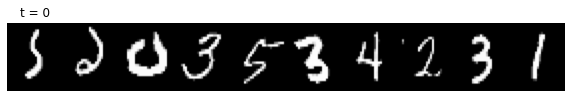

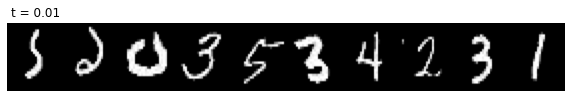

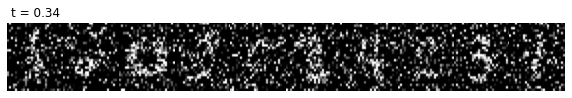

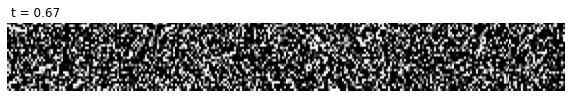

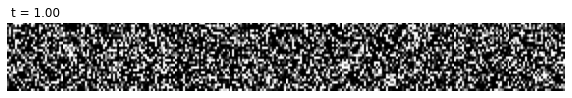

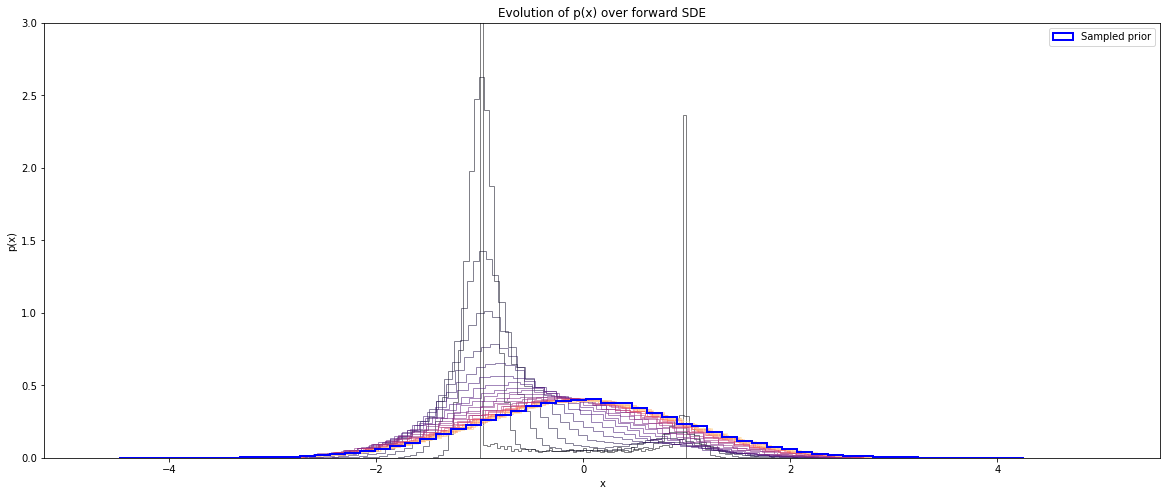

In [6]:
# Show some images after running the SDE forward for different times
time_steps = 4

x0, _ = next(iter(data_loader))
x0 = x0.cpu().numpy()

plot_mnist_digits(x0, grid_size=(10, 1), title="t = 0")
x0 = torch.tensor(x0).to(DEVICE)
for t in np.linspace(0.01, t_limit, time_steps):
    xt, score = sde.forward(x0, torch.full(x0.shape[:1], t).to(DEVICE))
    plot_mnist_digits(xt.cpu().numpy(), grid_size=(10, 1), title=("t = %.2f" % t))
    
# Show the transformation of the distribution of data to the prior distribution
time_steps = 30

all_t = np.linspace(0, t_limit, time_steps)
all_xt = np.empty((len(all_t),) + x0.shape)
for t_i, t in enumerate(all_t):
    xt, _ = sde.forward(x0, torch.ones(len(x0)).to(DEVICE) * t)
    all_xt[t_i] = xt.cpu().numpy()

fig, ax = plt.subplots(figsize=(20, 8))
cmap = plt.get_cmap("magma")
for t_i in range(len(all_t)):
    ax.hist(np.ravel(all_xt[t_i]), bins=60, histtype="step", color=cmap(t_i / len(all_t)), alpha=0.5, density=True)
prior = sde.sample_prior(len(x0), torch.ones(len(x0)).to(DEVICE) * t).cpu().numpy()
ax.hist(np.ravel(prior), bins=60, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
ax.set_xlabel("x")
ax.set_ylabel("p(x)")
ax.set_title("Evolution of p(x) over forward SDE")
ax.set_ylim((0, 3))
plt.legend()
plt.show()

### Train the model

### Show generated digits

In [7]:
train_continuous_model.train_ex.run(
    "train_branched_model",
    config_updates={
        "model": model,
        "sde": sde,
        "data_loader": data_loader,
        "class_time_to_branch_index": class_time_to_branch_tensor,
        "num_epochs": 120,
        "learning_rate": 0.001,
        "t_limit": t_limit,
        "loss_weighting_type": "empirical_norm"
    }
)

WARNING - root - Added new config entry: "class_time_to_branch_index"
WARNING - root - Added new config entry: "data_loader"
WARNING - root - Added new config entry: "loss_weighting_type"
WARNING - root - Added new config entry: "model"
WARNING - root - Added new config entry: "sde"
WARNING - root - Added new config entry: "t_limit"
INFO - train - Running command 'train_branched_model'
INFO - train - Started run with ID "2"
Loss: 89.28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 1 average Loss: 178.19


Loss: 89.31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 2 average Loss: 73.90


Loss: 62.09: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 3 average Loss: 58.56


Loss: 57.78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 4 average Loss: 51.32


Loss: 41.54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 5 average Loss: 47.47


Loss: 51.95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 6 average Loss: 44.12


Loss: 36.45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:47<00:00,  2.79it/s]


Epoch 7 average Loss: 41.59


Loss: 35.44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 8 average Loss: 40.40


Loss: 50.26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.79it/s]


Epoch 9 average Loss: 38.42


Loss: 42.36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 10 average Loss: 37.93


Loss: 40.33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 11 average Loss: 36.63


Loss: 45.10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 12 average Loss: 35.07


Loss: 42.43: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:47<00:00,  2.80it/s]


Epoch 13 average Loss: 35.14


Loss: 31.19: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.79it/s]


Epoch 14 average Loss: 34.90


Loss: 31.53: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 15 average Loss: 33.50


Loss: 46.86: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 16 average Loss: 32.96


Loss: 31.08: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 17 average Loss: 33.32


Loss: 28.27: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 18 average Loss: 32.20


Loss: 41.30: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 19 average Loss: 32.07


Loss: 35.52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 20 average Loss: 31.79


Loss: 27.57: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.79it/s]


Epoch 21 average Loss: 31.36


Loss: 34.93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 22 average Loss: 31.40


Loss: 21.71: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 23 average Loss: 31.05


Loss: 42.37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.79it/s]


Epoch 24 average Loss: 30.85


Loss: 36.42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.79it/s]


Epoch 25 average Loss: 30.36


Loss: 33.33: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 26 average Loss: 30.05


Loss: 24.09: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 27 average Loss: 29.96


Loss: 25.41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 28 average Loss: 29.75


Loss: 31.24: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 29 average Loss: 29.59


Loss: 26.52: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 30 average Loss: 29.20


Loss: 32.41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 31 average Loss: 29.19


Loss: 33.99: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.79it/s]


Epoch 32 average Loss: 28.83


Loss: 39.45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 33 average Loss: 28.79


Loss: 34.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 34 average Loss: 28.98


Loss: 27.03: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 35 average Loss: 28.35


Loss: 25.69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 36 average Loss: 28.31


Loss: 34.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.79it/s]


Epoch 37 average Loss: 28.18


Loss: 30.62: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 38 average Loss: 28.54


Loss: 26.04: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 39 average Loss: 28.02


Loss: 37.37: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 40 average Loss: 27.45


Loss: 32.69: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 41 average Loss: 27.82


Loss: 38.95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:47<00:00,  2.80it/s]


Epoch 42 average Loss: 27.15


Loss: 18.70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 43 average Loss: 27.91


Loss: 24.28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 44 average Loss: 27.53


Loss: 26.55: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 45 average Loss: 27.77


Loss: 32.42: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 46 average Loss: 27.34


Loss: 33.45: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 47 average Loss: 26.95


Loss: 25.70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 48 average Loss: 27.14


Loss: 30.93: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 49 average Loss: 27.13


Loss: 24.46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 50 average Loss: 27.11


Loss: 27.09: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 51 average Loss: 27.22


Loss: 26.82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:48<00:00,  2.78it/s]


Epoch 52 average Loss: 27.12


Loss: 29.36: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 53 average Loss: 26.60


Loss: 20.89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 54 average Loss: 26.31


Loss: 22.32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 55 average Loss: 26.61


Loss: 35.70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 56 average Loss: 26.49


Loss: 30.46: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.78it/s]


Epoch 57 average Loss: 26.42


Loss: 19.44: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 58 average Loss: 26.32


Loss: 20.54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 59 average Loss: 26.40


Loss: 29.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 60 average Loss: 26.72


Loss: 26.15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 61 average Loss: 26.35


Loss: 25.01: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 62 average Loss: 26.13


Loss: 19.18: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 63 average Loss: 26.06


Loss: 26.74: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 64 average Loss: 25.89


Loss: 24.76: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 65 average Loss: 25.89


Loss: 19.67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 66 average Loss: 26.07


Loss: 27.82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 67 average Loss: 25.78


Loss: 24.20: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 68 average Loss: 25.57


Loss: 20.03: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 69 average Loss: 25.89


Loss: 24.95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 70 average Loss: 25.62


Loss: 31.32: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 71 average Loss: 25.63


Loss: 21.49: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 72 average Loss: 25.60


Loss: 26.05: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.78it/s]


Epoch 73 average Loss: 25.74


Loss: 22.54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 74 average Loss: 25.95


Loss: 19.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 75 average Loss: 25.51


Loss: 20.96: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 76 average Loss: 25.25


Loss: 27.82: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 77 average Loss: 25.47


Loss: 23.90: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 78 average Loss: 25.62


Loss: 25.07: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 79 average Loss: 25.51


Loss: 19.97: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 80 average Loss: 25.33


Loss: 21.00: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 81 average Loss: 25.13


Loss: 23.34: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 82 average Loss: 24.91


Loss: 25.31: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 83 average Loss: 25.29


Loss: 20.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 84 average Loss: 24.94


Loss: 19.41: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 85 average Loss: 25.05


Loss: 23.80: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 86 average Loss: 24.94


Loss: 21.54: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 87 average Loss: 25.11


Loss: 24.65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 88 average Loss: 25.07


Loss: 32.11: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 89 average Loss: 24.77


Loss: 34.61: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 90 average Loss: 24.85


Loss: 22.06: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 91 average Loss: 24.93


Loss: 22.91: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 92 average Loss: 24.95


Loss: 20.67: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 93 average Loss: 25.30


Loss: 22.70: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 94 average Loss: 24.87


Loss: 24.26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 95 average Loss: 24.81


Loss: 23.65: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 96 average Loss: 24.98


Loss: 20.78: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 97 average Loss: 24.32


Loss: 19.95: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 98 average Loss: 24.55


Loss: 23.16: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 99 average Loss: 24.52


Loss: 19.29: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.76it/s]


Epoch 100 average Loss: 24.50


Loss: 19.03: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:51<00:00,  2.74it/s]


Epoch 101 average Loss: 24.71


Loss: 23.13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 102 average Loss: 24.43


Loss: 30.92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 103 average Loss: 24.65


Loss: 25.01: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 104 average Loss: 24.53


Loss: 31.92: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 105 average Loss: 24.36


Loss: 33.13: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:51<00:00,  2.74it/s]


Epoch 106 average Loss: 24.64


Loss: 21.89: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 107 average Loss: 24.46


Loss: 28.28: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 108 average Loss: 24.62


Loss: 23.64: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 109 average Loss: 24.20


Loss: 24.25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 110 average Loss: 24.37


Loss: 18.68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:51<00:00,  2.74it/s]


Epoch 111 average Loss: 24.34


Loss: 19.25: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:53<00:00,  2.71it/s]


Epoch 112 average Loss: 24.18


Loss: 16.85: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:52<00:00,  2.72it/s]


Epoch 113 average Loss: 24.15


Loss: 27.56: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.75it/s]


Epoch 114 average Loss: 24.32


Loss: 28.17: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:49<00:00,  2.77it/s]


Epoch 115 average Loss: 23.85


Loss: 22.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.74it/s]


Epoch 116 average Loss: 24.12


Loss: 20.26: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:51<00:00,  2.74it/s]


Epoch 117 average Loss: 24.47


Loss: 25.48: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:50<00:00,  2.76it/s]


Epoch 118 average Loss: 24.28


Loss: 26.12: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:52<00:00,  2.73it/s]


Epoch 119 average Loss: 24.50


Loss: 21.68: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 469/469 [02:52<00:00,  2.71it/s]
INFO - train - Completed after 5:39:36


Epoch 120 average Loss: 24.05


Sampling class: 0


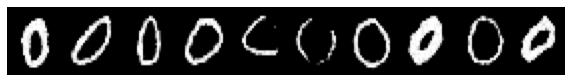

Sampling class: 1


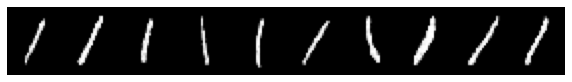

Sampling class: 2


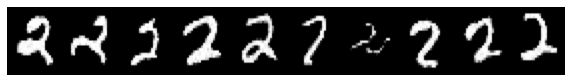

Sampling class: 3


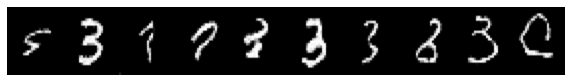

Sampling class: 4


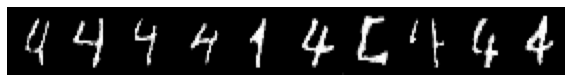

Sampling class: 5


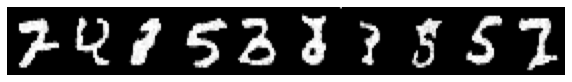

Sampling class: 6


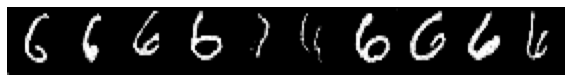

Sampling class: 7


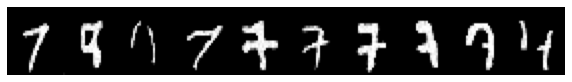

Sampling class: 8


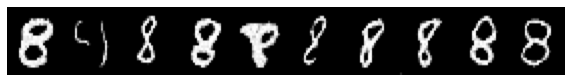

Sampling class: 9


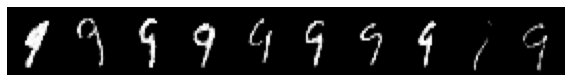

In [8]:
for class_to_sample in classes:
    print("Sampling class: %s" % class_to_sample)
    samples = generate.generate_continuous_branched_samples(
        model, sde, class_to_sample, class_time_to_branch_tensor,
        sampler="pc", t_limit=t_limit
    )
    plot_mnist_digits(samples.cpu().numpy(), grid_size=(10, 1), title=None)

**Intermediate states**

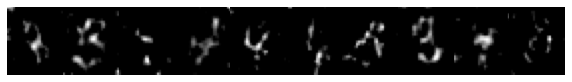

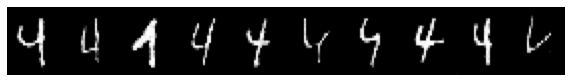

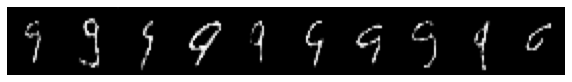

In [9]:
branch_time_4_9 = 0.35

samples_49 = generate.generate_continuous_branched_samples(
    model, sde, 4, class_time_to_branch_tensor, sampler="pc", t_start=branch_time_4_9,
    t_limit=t_limit
).cpu().numpy()
samples_4 = generate.generate_continuous_branched_samples(
    model, sde, 4, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time_4_9,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()
samples_9 = generate.generate_continuous_branched_samples(
    model, sde, 9, class_time_to_branch_tensor, sampler="pc", t_limit=branch_time_4_9,
    initial_samples=torch.tensor(samples_49).to(DEVICE)
).cpu().numpy()

smoothed_samples_49 = np.empty_like(samples_49)
for i in range(len(samples_49)):
    smoothed_samples_49[i, 0] = scipy.ndimage.gaussian_filter(samples_49[i, 0], sigma=1)
    
plot_mnist_digits(smoothed_samples_49)
plot_mnist_digits(samples_4)
plot_mnist_digits(samples_9)

**Diffusing from one class to another**

/local/56864417/ipykernel_29354/877947954.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)


4 to 9


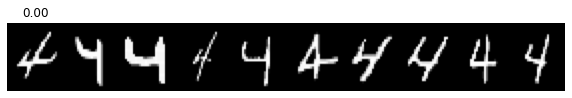

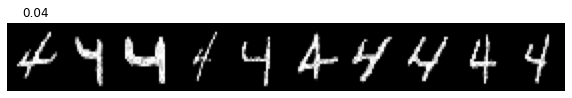

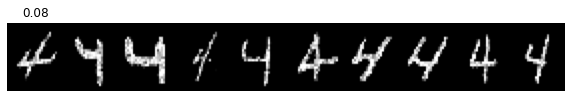

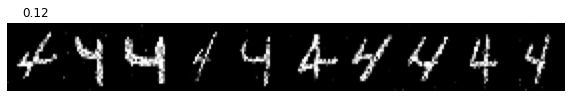

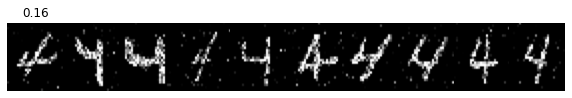

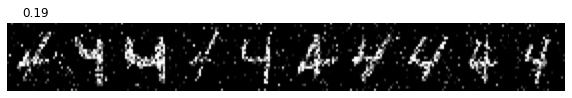

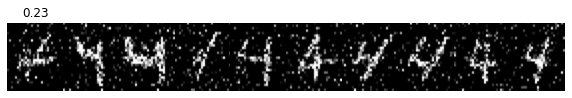

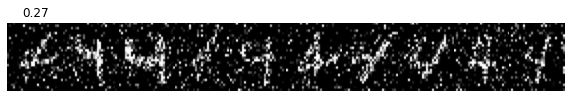

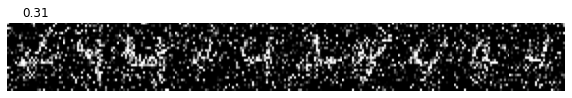

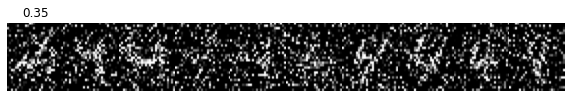

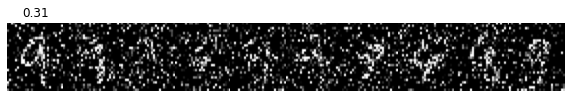

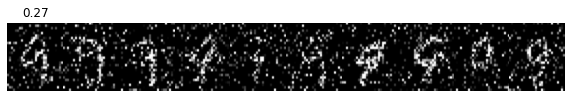

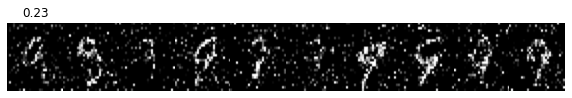

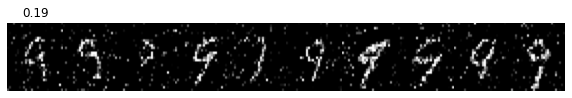

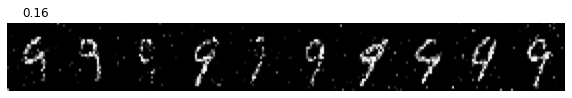

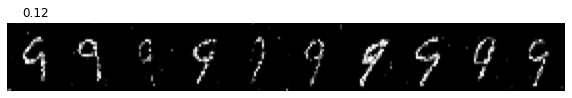

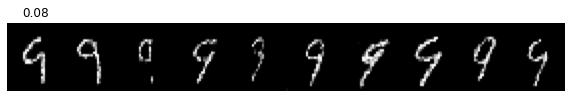

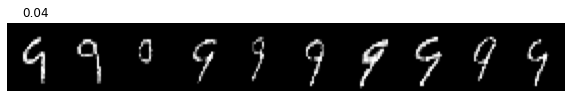

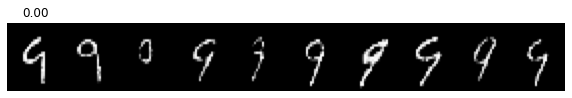

9 to 4


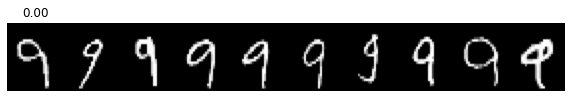

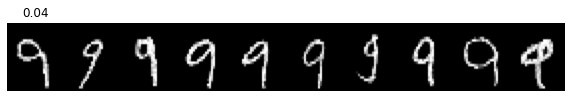

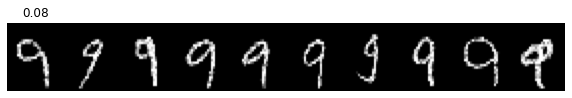

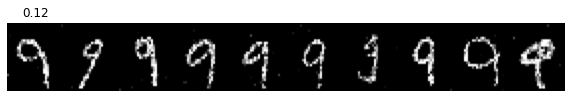

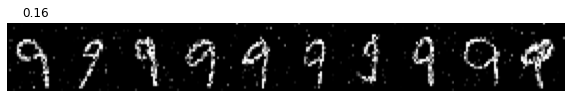

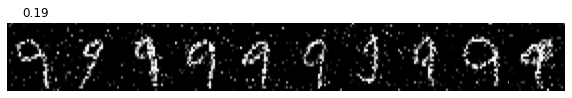

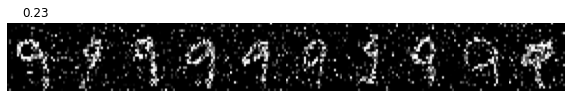

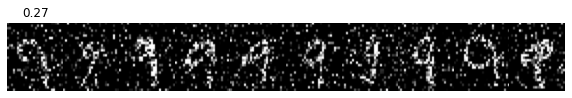

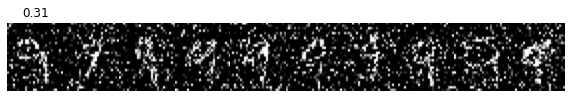

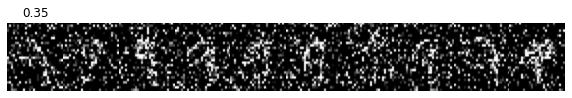

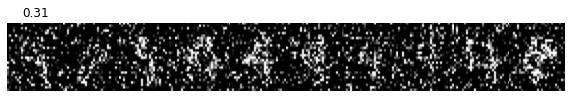

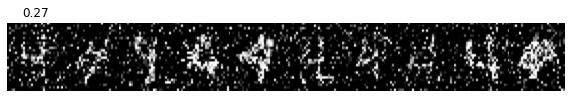

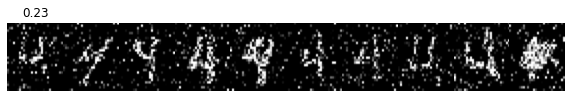

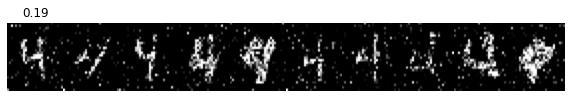

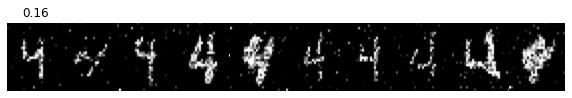

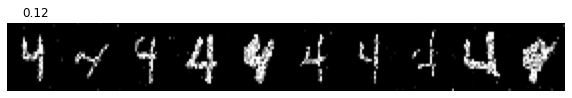

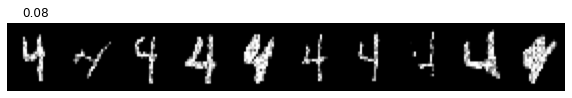

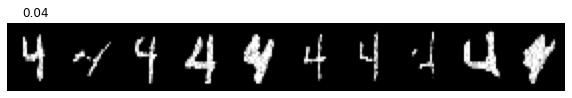

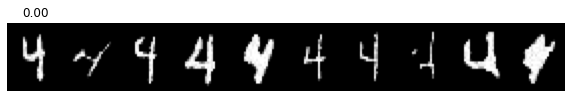

In [10]:
orig_4 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 4)[0], size=32, replace=False)
])
orig_9 = torch.stack([
    torch.tensor(dataset[i][0], device=DEVICE) for i in 
    np.random.choice(np.where(dataset.targets == 9)[0], size=32, replace=False)
])

time_steps = 10
all_t = np.linspace(0, branch_time_4_9, time_steps)
forward_4_to_9 = np.empty((len(all_t),) + orig_4.shape)
backward_4_to_9 = np.empty((len(all_t) - 1,) + orig_4.shape)
forward_9_to_4 = np.empty((len(all_t),) + orig_4.shape)
backward_9_to_4 = np.empty((len(all_t) - 1,) + orig_4.shape)
orig_4_tens, orig_9_tens = torch.tensor(orig_4).to(DEVICE), torch.tensor(orig_9).to(DEVICE)
for t_i, t in enumerate(all_t):
    forward_4_to_9[t_i] = sde.forward(
        orig_4_tens, torch.ones(len(orig_4_tens)).to(DEVICE) * t
    )[0].cpu().numpy()
    forward_9_to_4[t_i] = sde.forward(
        orig_9_tens, torch.ones(len(orig_9_tens)).to(DEVICE) * t
    )[0].cpu().numpy()

all_t_flip = np.flip(all_t)
last_4_to_9 = torch.tensor(forward_4_to_9[-1]).to(DEVICE).float()
last_9_to_4 = torch.tensor(forward_9_to_4[-1]).to(DEVICE).float()
for t_i in range(len(all_t_flip) - 1):
    last_4_to_9 = generate.generate_continuous_branched_samples(
        model, sde, 9, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_4.shape[0], initial_samples=last_4_to_9,
        num_steps=50
    )
    backward_4_to_9[t_i] = last_4_to_9.cpu().numpy()
    
    last_9_to_4 = generate.generate_continuous_branched_samples(
        model, sde, 4, class_time_to_branch_tensor, sampler="pc",
        t_limit=all_t_flip[t_i], t_start=all_t_flip[t_i + 1],
        num_samples=orig_9.shape[0], initial_samples=last_9_to_4,
        num_steps=50
    )
    backward_9_to_4[t_i] = last_9_to_4.cpu().numpy()
    
print("4 to 9")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_4_to_9[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_4_to_9[t_i], title=("%.2f" % t))

print("9 to 4")
for t_i, t in enumerate(all_t):
    plot_mnist_digits(forward_9_to_4[t_i], title=("%.2f" % t))
for t_i, t in enumerate(all_t_flip[1:]):
    plot_mnist_digits(backward_9_to_4[t_i], title=("%.2f" % t))